# A simple QNN to evaluate capacity of ansatzes

As we learned from the prior notebook, the QNN isn't able to learn the underlying distribution behind `DIS`. So now we pose the question: "how many datapoints *can* the parameterized quantum circuit learn?" Which sparked us to investigate the relationship between certain ansatz structures and the learnability of the QNN over n data samples. All loss and accuracy metric charts have been added to have been added to `root/hyperparameter_training_logs.md` which you can visit [here](https://github.com/Sinestro38/qosf-qgan/blob/main/Hyperparameter_tuning_logs.pdf). This notebook contains the code we used to evaluate the learnability of the QNN as the number of data samples scales.

<hr>

## Imports

In [1]:
import datetime
import time
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

dataset structure: `[equity number][train or test][sample number][past or future daily close prices (normalized percentage difference)]`

In [2]:
dataset = np.load('data/dataset.npy', allow_pickle=True)

In [3]:
dis_dataset = dataset[1] # normalized percentage diff close prices of DIS

## QNN Structure

In [7]:
latent_dim = 0
wires = range(len(dis_dataset[0][0][0]) + latent_dim)
n_layers = 3
dev = qml.device('default.qubit', wires=wires)

In [9]:
@qml.qnode(dev, interface="tf")
def qnn(inputs, weights):
    # Embedding past time series onto circuit
    qml.templates.AngleEmbedding(inputs, wires[:len(dis_dataset[0][1][0])], rotation='X')
    
    # Ansatz of choice
    qml.templates.StronglyEntanglingLayers(weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dis_dataset[0][1][1]))]

In [11]:
init_weights = tf.Variable(np.random.uniform(-np.pi, np.pi, (n_layers, len(wires), 3)))

## One train step

In [12]:
opt = tf.keras.optimizers.Adam(lr=0.0002)

In [13]:
mse = tf.keras.losses.MeanSquaredError()
def accuracy(y_true, y_pred):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(y_true, y_pred)
    acc = 1 - m.result().numpy()
    return acc

In [14]:
def train_step(equity_data, gen_weights):
    """Run train step on provided image batch."""
    with tf.GradientTape() as gen_tape: 
        pred_prices = qnn(equity_data[0], gen_weights)
        loss = mse(equity_data[1], pred_prices)
    
    grad = gen_tape.gradient(loss, gen_weights)
    opt.apply_gradients(zip([grad], [gen_weights]))
    
    """Accuracy"""
    acc = accuracy(equity_data[1], qnn(equity_data[0], gen_weights))
    
    return loss, gen_weights, acc

## Training

In [337]:
gloss = []
acc_results = []
acc_results_avg = []

In [338]:
EPOCHS = 1000
batch_size = 1

def train(dataset, epochs, start_epoch=1, new_gen_w=None):    
    for epoch in range(start_epoch, start_epoch + epochs):
        if epoch == 1:
            new_gen_w = tf.Variable(np.ones_like(init_weights.numpy()), dtype="float64")
            new_gen_w.assign(init_weights)
        
        for i, sample in enumerate(dataset[0:batch_size]):
            sample_b = sample[0]
            sample_f = sample[1]
            gl, w, acc = train_step(dataset[i], new_gen_w)
            
            new_gen_w.assign(w)
            acc_results.append(acc)
            gloss.append(gl)

            tf.summary.scalar('Generator Loss', data=gl.numpy(), step=epoch)
            tf.summary.scalar('Prediction Accuracy', data=acc, step=epoch)
        
            if epoch % 10 == 0:
                print(f"Step {i} in {epoch} epoch: Gen loss: {gl} \n             Accuracy: {acc}")
        
        """Average accuracy of QNN"""
        epoch_acc = 0
        for i, sample in enumerate(dataset[0:batch_size]):
            epoch_acc += accuracy(sample[1], qnn(sample[0], new_gen_w))
        epoch_acc = epoch_acc / len(dataset[0:batch_size])
        acc_results_avg.append(epoch_acc)

    return new_gen_w

In [339]:
new_gen_w = train(dis_dataset[0], EPOCHS, start_epoch=1) 

Step 0 in 10 epoch: Gen loss: 0.5000439882278442 
             Accuracy: 0.2963937520980835
Step 0 in 20 epoch: Gen loss: 0.4981929063796997 
             Accuracy: 0.2978220582008362
Step 0 in 30 epoch: Gen loss: 0.4963444769382477 
             Accuracy: 0.29925036430358887
Step 0 in 40 epoch: Gen loss: 0.49449390172958374 
             Accuracy: 0.30068111419677734
Step 0 in 50 epoch: Gen loss: 0.49263787269592285 
             Accuracy: 0.3021184206008911
Step 0 in 60 epoch: Gen loss: 0.4907742142677307 
             Accuracy: 0.30356478691101074
Step 0 in 70 epoch: Gen loss: 0.48890089988708496 
             Accuracy: 0.30502235889434814
Step 0 in 80 epoch: Gen loss: 0.48701590299606323 
             Accuracy: 0.3064926862716675
Step 0 in 90 epoch: Gen loss: 0.4851173162460327 
             Accuracy: 0.307977557182312
Step 0 in 100 epoch: Gen loss: 0.483203649520874 
             Accuracy: 0.30947816371917725
Step 0 in 110 epoch: Gen loss: 0.4812740683555603 
             Accuracy

## Training metrics

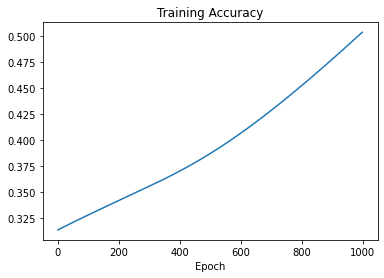

In [313]:
plt.plot(range(len(acc_results_avg)), acc_results_avg)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.show()

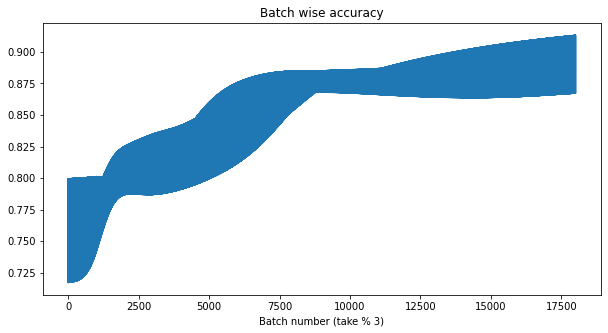

In [257]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(acc_results)), acc_results)
plt.title("Batch wise accuracy")
plt.xlabel(f"Batch number (take % {batch_size})")
plt.show()

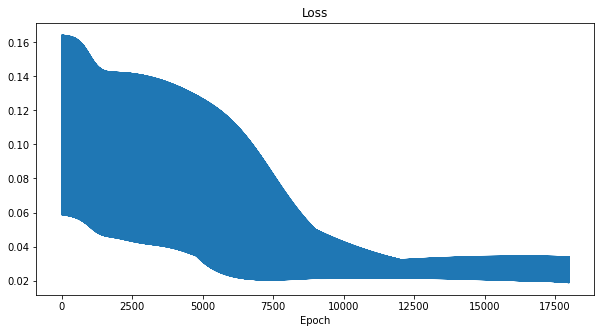

In [258]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(gloss)), gloss, label="Training Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()

## Results compared

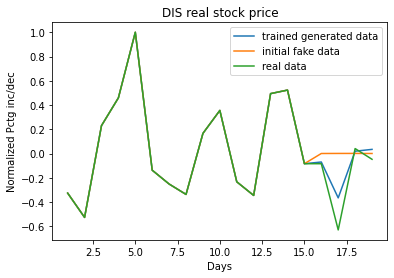

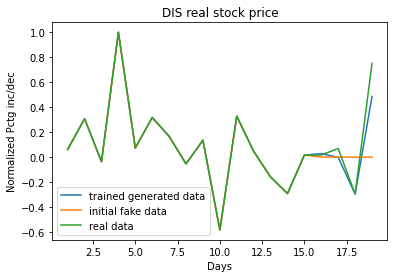

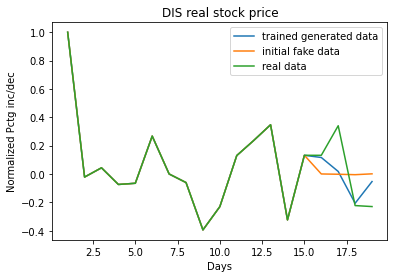

In [259]:
for i in range(batch_size):
    days =  np.arange(1, len(dis_dataset[0][0][0]) + len(dis_dataset[0][0][1]) + 1)
    real_stats = np.append(dis_dataset[0][i][0], dis_dataset[0][i][1])
    fake_stats = tf.concat([dis_dataset[0][i][0], qnn(dis_dataset[0][i][0], new_gen_w)], 0).numpy()
    init_fake_stats = tf.concat([dis_dataset[0][i][0], qnn(dis_dataset[0][i][0], init_weights)], 0).numpy()

    plt.plot(days, fake_stats, label="trained generated data")
    plt.plot(days, init_fake_stats, label="initial fake data")
    plt.plot(days, real_stats, label="real data")
    plt.title("DIS real stock price")
    plt.xlabel("Days")
    plt.ylabel("Normalized Pctg inc/dec")
    plt.legend()
    plt.show()

<hr>

## Conclusion

Given time constraints and the exponential time consumption of the training, we were unable to evaluate the upper bound of the QNN. However, we conclude that QNN was able to learn three distinct price data sequences of length 19 given the Gaussian latent input space. Next, we move on to explore the applicability of QGANs in this learning task.